### Initial Experiments

- Week: 3 / 15
- Author: Amiri Hayes
- Goal: Test TAG simulation methods & compare any biases on sample graphs

In [9]:
# !pip install graph_tool

# import graph_tool.all as gt
import networkx as nx
import numpy as np
np.random.seed(42)
print("import successful")

import successful


In [17]:
import numpy as np
import networkx as nx

def generate_sbm_numpy(block_sizes, probs, seed=None):
    if seed is not None:
        np.random.seed(seed)
    N = sum(block_sizes)
    labels = np.repeat(np.arange(len(block_sizes)), block_sizes)
    adj = np.zeros((N, N), dtype=int)
    
    for i in range(N):
        for j in range(i, N):
            p = probs[labels[i], labels[j]]
            if np.random.rand() < p:
                adj[i, j] = 1
                adj[j, i] = 1
    G = nx.from_numpy_array(adj)
    return G

# Parameters
num_graphs = 1_00
block_sizes = [10, 10, 10, 10, 10]  # 5 blocks, 50 nodes
probs = np.array([
    [0.8, 0.05, 0.05, 0.05, 0.05],
    [0.05, 0.8, 0.05, 0.05, 0.05],
    [0.05, 0.05, 0.8, 0.05, 0.05],
    [0.05, 0.05, 0.05, 0.8, 0.05],
    [0.05, 0.05, 0.05, 0.05, 0.8]
])

numpy_graphs = [generate_sbm_numpy(block_sizes, probs, seed=i) for i in range(num_graphs)]
nx_graphs = [nx.stochastic_block_model(block_sizes, probs, seed=i) for i in range(num_graphs)]

In [ ]:
from collections import defaultdict

def compute_summary_stats(G, block_sizes):
    stats = {}
    stats['num_edges'] = G.number_of_edges()
    stats['density'] = nx.density(G)
    stats['avg_clustering'] = nx.average_clustering(G)
    stats['diameter'] = nx.diameter(G) if nx.is_connected(G) else 0
    stats['max_degree'] = max(dict(G.degree()).values())
    stats['min_degree'] = min(dict(G.degree()).values())
    stats['avg_degree'] = sum(dict(G.degree()).values()) / G.number_of_nodes()
    stats['assortativity'] = nx.degree_pearson_correlation_coefficient(G)
    stats['modularity'] = nx.algorithms.community.modularity(G, [list(range(sum(block_sizes[:i]), sum(block_sizes[:i+1]))) for i in range(len(block_sizes))])
    return stats

summary_statistics = defaultdict(list)

for G in numpy_graphs + nx_graphs:
    stats = compute_summary_stats(G, block_sizes)
    for k, v in stats.items():
        summary_statistics[k].append(v)

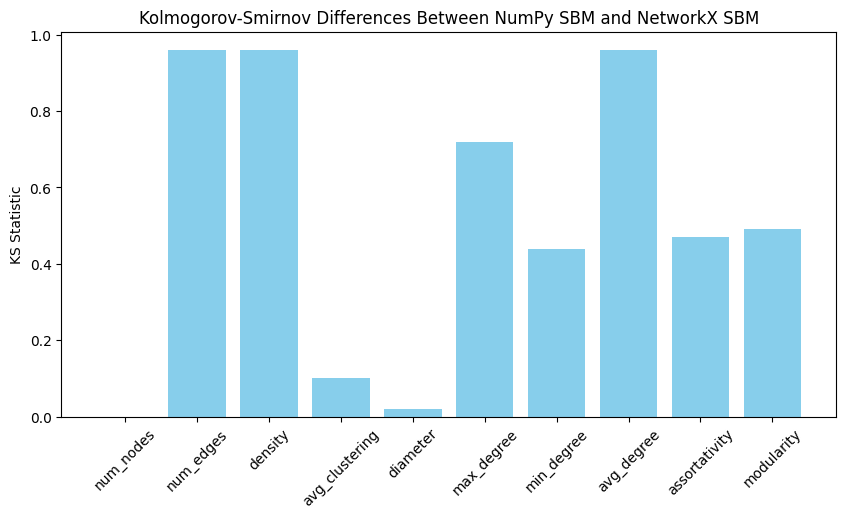

Statistic with highest difference: num_edges


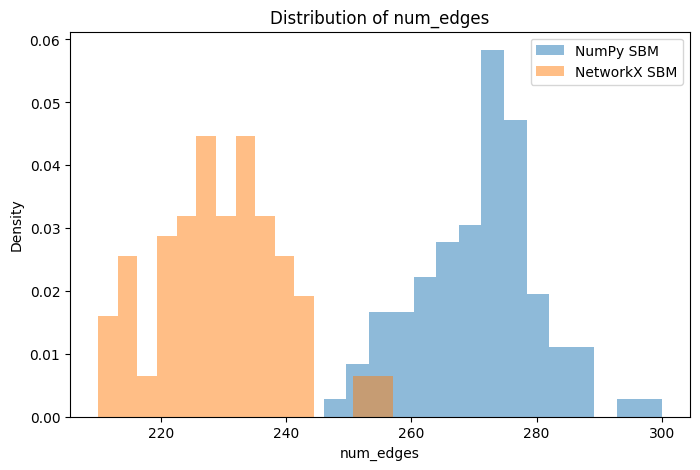

       num_nodes   num_edges     density  avg_clustering    diameter  \
count      200.0  200.000000  200.000000      200.000000  200.000000   
mean        50.0  250.030000    0.204106        0.530482    3.895000   
std          0.0   22.810099    0.018620        0.035498    0.380393   
min         50.0  210.000000    0.171429        0.450829    3.000000   
25%         50.0  229.000000    0.186939        0.503523    4.000000   
50%         50.0  251.000000    0.204898        0.530073    4.000000   
75%         50.0  272.000000    0.222041        0.552986    4.000000   
max         50.0  300.000000    0.244898        0.623122    5.000000   

       max_degree  min_degree  avg_degree  assortativity  modularity  
count  200.000000  200.000000  200.000000     200.000000  200.000000  
mean    14.385000    5.900000   10.001200       0.026599    0.599031  
std      1.451658    1.107308    0.912404       0.072117    0.027476  
min     11.000000    2.000000    8.400000      -0.162859    0.52333

In [19]:
import matplotlib.pyplot as plt
from scipy.stats import ks_2samp
import pandas as pd

# Compute KS scores between the first 100 (numpy) and second 100 (networkx) samples
ks_scores = {}
for stat, values in summary_statistics.items():
    ks_stat, p_val = ks_2samp(values[:num_graphs], values[num_graphs:])
    ks_scores[stat] = ks_stat

# Bar chart of KS statistics
plt.figure(figsize=(10, 5))
plt.bar(ks_scores.keys(), ks_scores.values(), color='skyblue')
plt.xticks(rotation=45)
plt.ylabel('KS Statistic')
plt.title('Kolmogorov-Smirnov Differences Between NumPy SBM and NetworkX SBM')
plt.show()

# Identify the statistic with highest KS difference
max_stat = max(ks_scores, key=ks_scores.get)
print(f"Statistic with highest difference: {max_stat}")

# Probability distribution plot for the most different statistic
plt.figure(figsize=(8, 5))
plt.hist(summary_statistics[max_stat][:num_graphs], bins=15, alpha=0.5, label='NumPy SBM', density=True)
plt.hist(summary_statistics[max_stat][num_graphs:], bins=15, alpha=0.5, label='NetworkX SBM', density=True)
plt.title(f'Distribution of {max_stat}')
plt.xlabel(max_stat)
plt.ylabel('Density')
plt.legend()
plt.show()

# Summary table of statistics
summary_df = pd.DataFrame(summary_statistics)
print(summary_df.describe())
